In [97]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
data = pd.read_csv("/storage/mgymrek/ssc-imputation/pilot-imputation/str-imputation/imputation_results.txt", 
                   sep="\t", names=["locus", "refac", "altac", "sample", "truth", "Q", "PQ", "DP", "locus2", \
                                       "imputed", "ref", "alt"])
data = data[data["truth"]!="."]

Populating the interactive namespace from numpy and matplotlib


In [105]:
def GetAlleles(x, col):
    if x[col] == ".": return "."
    lengths = [len(x.ref)] + [len(item) for item in x.alt.split(",")]
    gts = [int(item) for item in x[col].split("|")]
    return "%s,%s"%(lengths[gts[0]], lengths[gts[1]])
def GetDosage(x, col):
    if x[col] == ".": return "."
    return sum([int(item) for item in x[col+"_alleles"].split(",")])
def GetAFreqs(x):
    if x["truth"] == ".": return "."
    freqs = [float(x.refac)] + [float(item) for item in x.altac.split(",")]
    freqs = [item*1.0/sum(freqs) for item in freqs]
    gts = [int(item) for item in x["truth"].split("|")]
    return "%s,%s"%(freqs[gts[0]], freqs[gts[1]])

data["truth_alleles"] = data.apply(lambda x: GetAlleles(x, "truth"), 1)
data["truth_dosage"] = data.apply(lambda x: GetDosage(x, "truth"), 1)
data["imputed_alleles"] = data.apply(lambda x: GetAlleles(x, "imputed"), 1)
data["imputed_dosage"] = data.apply(lambda x: GetDosage(x, "imputed"), 1)
data["correct"] = data.apply(lambda x: int(x["truth_dosage"]) == int(x["imputed_dosage"]), 1)
data["afreqs"] = data.apply(GetAFreqs, 1)
data["minaf"] = data.apply(lambda x: min([float(af) for af in x.afreqs.split(",")]), 1)

In [70]:
def BubblePlot(x, title="all"):
    counts = x.groupby(["truth_dosage","imputed_dosage"], as_index=False).agg({"sample": len})
    r2 = scipy.stats.pearsonr(x["truth_dosage"], x["imputed_dosage"])[0]**2
    fig = plt.figure()
    ax = fig.add_subplot(111)
    minallele = min(list(counts["truth_dosage"])+list(counts["imputed_dosage"]))
    maxallele = max(list(counts["truth_dosage"])+list(counts["imputed_dosage"]))
    ax.scatter(counts["truth_dosage"], counts["imputed_dosage"], s=(counts["sample"])**2)
    ax.plot([minallele-1, maxallele+1], [minallele-1, maxallele+1], color="gray", linestyle="dashed")
    ax.set_xlim(left=minallele-1, right=maxallele+1)
    ax.set_ylim(bottom=minallele-1, top=maxallele+1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_xlabel("HipSTR genotype", size=15)
    ax.set_ylabel("Imputed genotype", size=15)
    ax.set_xticklabels(ax.get_xticks(), size=12)
    ax.set_yticklabels(ax.get_yticks(), size=12)
    ax.set_title(title + " r2=" + str(r2))

/usr/lib64/python3.4/site-packages/scipy/stats/stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


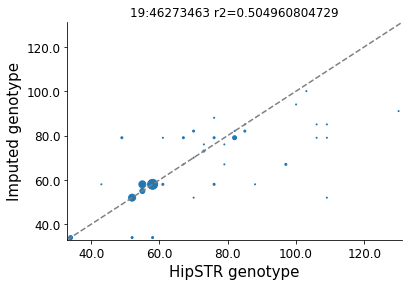

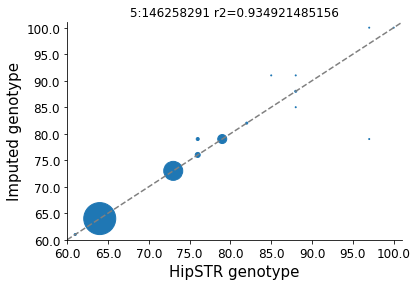

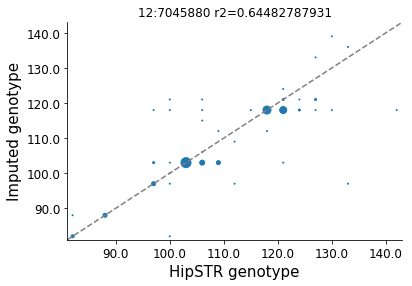

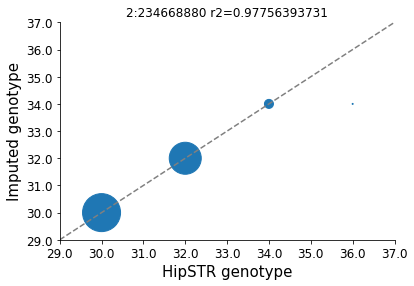

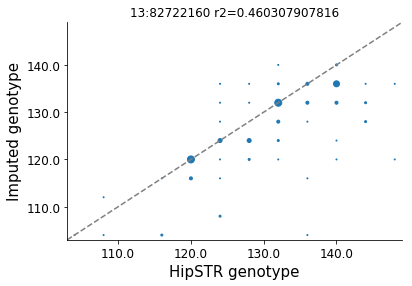

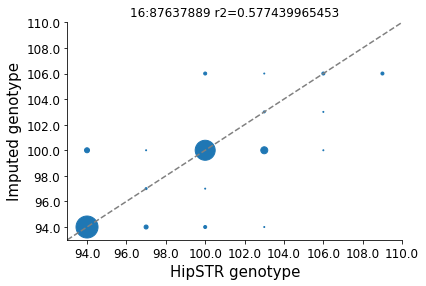

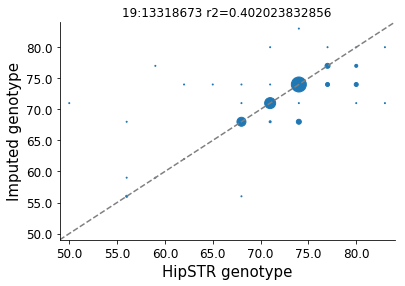

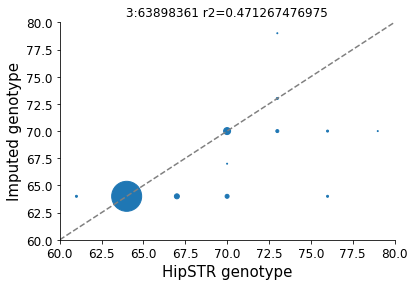

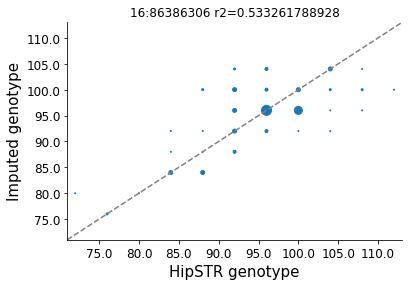

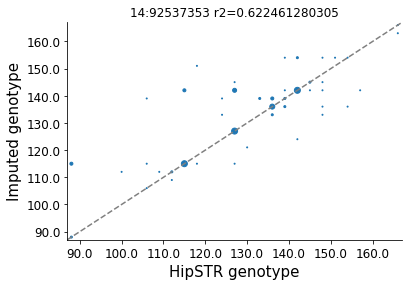

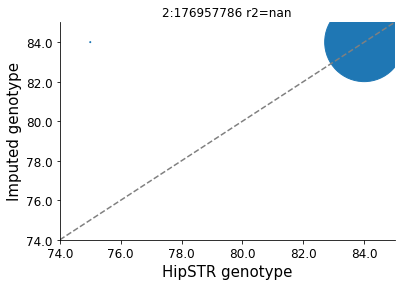

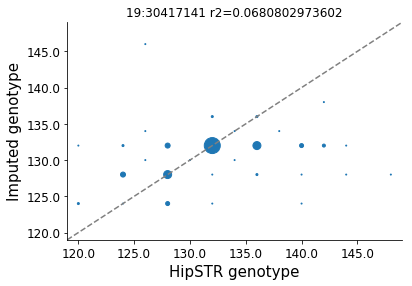

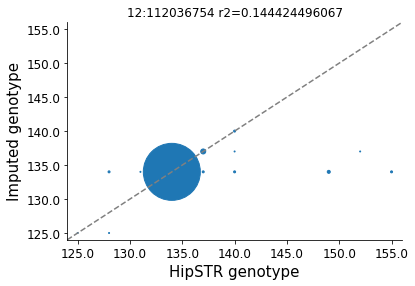

In [84]:
loci = list(set(data["locus"]))
r2vals = []
accvals = []
rlen = []
for locus in loci:
    x = data[(data["locus"]==locus)]
    r2 = scipy.stats.pearsonr(x["truth_dosage"].apply(int), x["imputed_dosage"].apply(int))[0]**2
    BubblePlot(x, title=locus)
    r2vals.append(r2)
    accvals.append(np.mean(x["correct"]))
    rlen.append(len(x.ref.values[0]))

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


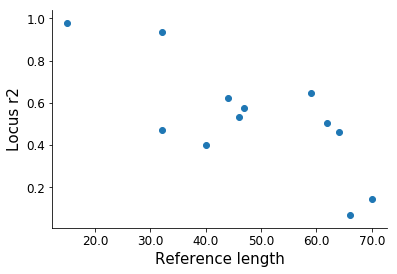

In [87]:
# Check r2 vs. length
res = pd.DataFrame({"locus": loci, "r2": r2vals, "rlen": rlen, "acc": accvals})
res.sort("r2")
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(res["rlen"], res["r2"])
ax.set_xlabel("Reference length", size=15)
ax.set_ylabel("Locus r2", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');

In [88]:
res

,acc,locus,r2,rlen
0,0.405063,19:46273463,0.504961,62
1,0.900000,5:146258291,0.934921,32
2,0.412500,12:7045880,0.644828,59
3,0.987500,2:234668880,0.977564,15
4,0.312500,13:82722160,0.460308,64
5,0.612500,16:87637889,0.577440,47
6,0.562500,19:13318673,0.402024,40
7,0.650000,3:63898361,0.471267,32
8,0.375000,16:86386306,0.533262,46
9,0.425000,14:92537353,0.622461,44


In [118]:
# Check accuracy vs. call quality

print("coverage")
for dp in np.arange(5, 70, 5):
    x = data[data["DP"].apply(int)>=dp]
    acc = np.mean(x["correct"])
    print("%s %s"%(dp, acc))

print("score")
for q in np.arange(0, 1.1, 0.25):
    x = data[data["Q"].apply(float)>=q]
    acc = np.mean(x["correct"])
    print("%s %s"%(q, acc))
    
print("pscore")
for pq in np.arange(0, 1.1, 0.25):
    x = data[data["PQ"].apply(float)>=pq]
    acc = np.mean(x["correct"])
    print("%s %s"%(pq, acc))
    
print("afreq")
afbins = [(0, 0.01), (0.01, 0.05), (0.05, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 1.0)]
for afb in afbins:
    x = data[(data["minaf"]>=afb[0]) & (data["minaf"]<afb[1])]
    acc = np.mean(x["correct"])
    print("%s %s"%(str(afb), acc))

coverage
5 0.60157016683
10 0.602385685885
15 0.603850050659
20 0.597251585624
25 0.583529411765
30 0.559274755927
35 0.523156089194
40 0.494004796163
45 0.491694352159
50 0.432291666667
55 0.448979591837
60 0.45652173913
65 0.346153846154
score
0.0 0.60157016683
0.25 0.600786627335
0.5 0.600597609562
0.75 0.604251012146
1.0 0.608315098468
pscore
0.0 0.60157016683
0.25 0.601184600197
0.5 0.609582059123
0.75 0.720930232558
1.0 0.72255489022
afreq
(0, 0.01) 0.0
(0.01, 0.05) 0.190909090909
(0.05, 0.1) 0.36690647482
(0.1, 0.2) 0.52358490566
(0.2, 0.3) 0.65445026178
(0.3, 0.4) 0.837606837607
(0.4, 1.0) 0.97641509434


In [110]:
data[data["minaf"]<0.01][["locus","sample","truth","imputed","afreqs","correct"]]

,locus,sample,truth,imputed,afreqs,correct
31,12:112036754,SSC00668,5|12,5|5,"0.746875,0.009375",False
44,12:112036754,SSC00675,5|12,5|5,"0.746875,0.009375",False
58,13:82722160,SSC02051,13|0,5|8,"0.009375,0.1",False
71,13:82722160,SSC02092,13|0,5|8,"0.009375,0.1",False
119,3:63898361,SSC02926,0|8,4|0,"0.686956521739,0.00869565217391",False
161,12:112036754,SSC03093,5|3,5|5,"0.746875,0.009375",False
173,12:7045880,SSC04977,0|5,0|3,"0.340625,0.00625",False
199,12:7045880,SSC05051,2|10,0|9,"0.009375,0.053125",False
200,12:112036754,SSC05051,2|5,5|5,"0.009375,0.746875",False
361,19:13318673,SSC05767,1|5,5|4,"0.00625,0.2",False
